In [1]:
import time
import imageio
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras import backend as K
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

tf.compat.v1.disable_eager_execution()

%matplotlib inline

In [2]:
# This is the path to the image you want to transform.
target_image_path = './images/eiffel.jpg'

# This is the path to the style image.
style_reference_image_path = './images/thescream.jpg'

result_prefix = style_reference_image_path.split("images/")[1][:-4] + '_onto_'\
                + target_image_path.split("images/")[1][:-4]

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel and adding standardizing values to B,G,R channels respectively
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8') # limits the value of x between 0 and 255
    return x

In [3]:
def content_loss(target, final):
    return K.sum(K.square(target-final))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, final_img):
    S = gram_matrix(style)
    F = gram_matrix(final_img)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - F)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Load vgg16 model

In [4]:
# load reference image and style image
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our final generated image
final_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              final_image], axis=0)

# We build the VGG16 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

print('Model loaded.')

Model loaded.


## Computing losses

In [5]:
# creatin a dictionary containing layer_name:layer_output
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Name of layer used for content loss 
content_layer = 'block5_conv2'

# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-4 #(randomly taken)
style_weight = 1.             #(randomly taken)
content_weight = 0.025        #(randomly taken)

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :] #as we concatenated them above and here 1 will be style fetures
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,combination_features)# adding content loss

for layer_name in style_layers:
    
    layer_features = outputs_dict[layer_name]
    
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    sl = style_loss(style_reference_features, combination_features)
    loss += sl * (style_weight / len(style_layers))      #adding style loss

loss += total_variation_weight * total_variation_loss(final_image)

# Get the gradient of the loss wrt the final image means how is loss changing wrt final image
grads = K.gradients(loss, final_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([final_image], [loss, grads])

In [7]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [8]:
# After 10 iterations little change occurs
iterations = 10

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()

# fmin_l_bfgs_b(func,x) minimizes a function func using the L-BFGS-B algorithm where 
# x is the initial guess
# fprime is gradient of the function
# maxfun is Maximum number of function evaluations.

# returns x which is Estimated position of the minimum.
# minval -> Value of func at the minimum.

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    estiated_min, func_val_at_min, info = fmin_l_bfgs_b(evaluator.loss, x,fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', func_val_at_min)
    
    # Save current generated image
    img = estiated_min.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = "./outputs/" + result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    print('\n')

Start of iteration 0
Current loss value: 606037600.0
Image saved as ./outputs/thescream_onto_eiffel_at_iteration_0.png
Iteration 0 completed in 21s


Start of iteration 1
Current loss value: 580444300.0
Image saved as ./outputs/thescream_onto_eiffel_at_iteration_1.png
Iteration 1 completed in 8s


Start of iteration 2
Current loss value: 581445500.0
Image saved as ./outputs/thescream_onto_eiffel_at_iteration_2.png
Iteration 2 completed in 8s


Start of iteration 3
Current loss value: 580231550.0
Image saved as ./outputs/thescream_onto_eiffel_at_iteration_3.png
Iteration 3 completed in 8s


Start of iteration 4
Current loss value: 581114500.0
Image saved as ./outputs/thescream_onto_eiffel_at_iteration_4.png
Iteration 4 completed in 8s


Start of iteration 5
Current loss value: 605846400.0
Image saved as ./outputs/thescream_onto_eiffel_at_iteration_5.png
Iteration 5 completed in 8s


Start of iteration 6
Current loss value: 581633300.0
Image saved as ./outputs/thescream_onto_eiffel_at_it

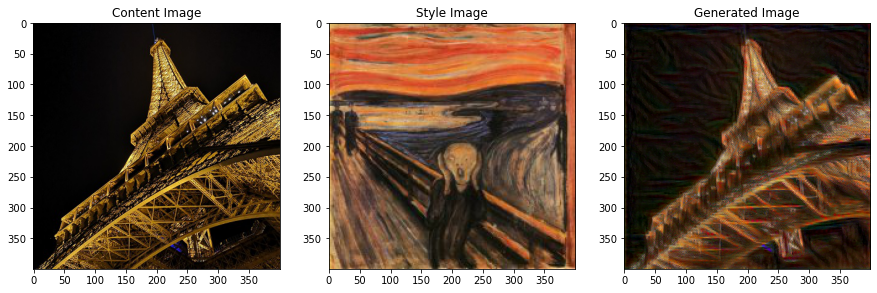

In [22]:
plt.figure(figsize=(15,8))

# Content image
plt.subplot(131)
plt.title('Content Image')
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))

# Style image
plt.subplot(132)
plt.title('Style Image')
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))

# Generate image
plt.subplot(133)
plt.title('Generated Image')
plt.imshow(img)

